# Instantons

In [2]:
%matplotlib inline

In [1]:
import os,sys
sys.path.append('./bubbles_codes/')
from bubble_tools import *
from experiment import *
from plotting import *

In [3]:
bubbleList, instantonList, tmpList = [], [], []
for tmp in [0,1,2,3]:
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    bubbleList.append(np.load(average_file(*exp_params)))
    instantonList.append(np.load(supercrit_instanton_file(*exp_params)))
    tmpList.append(tmp)


In [4]:
def FWHM(X,Y):
    half_max = np.amax(Y)/2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = (half_max - Y[:-1]) - (half_max - Y[1:])
    plt.plot(X[0:len(d)], d) #if you are interested
    #find the left and right most indexes
    left_idx = np.argwhere(d > 0)[0]; plt.axvline(left_idx, color='r')
    right_idx = np.argwhere(d < 0)[-1]; plt.axvline(right_idx, color='r'); plt.show()
    return X[right_idx] - X[left_idx] #return the difference (full width)

In [5]:
%run 'bubbles_codes/plotting.py'

0 3 401 401


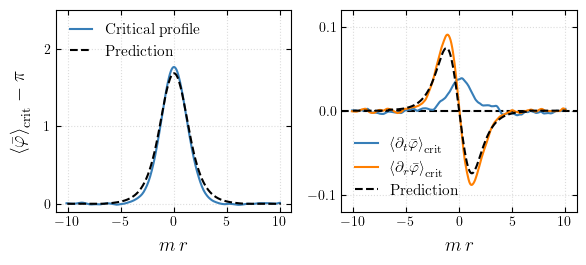

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (6., 2.8))
ax[0].set_ylim(-0.1, 2.5)
ax[1].set_ylim(-0.12, 0.12)
ax[0].set_ylabel(r'$\left<\bar{\varphi}\right>_{\rm crit} - \pi$')
ax[1].axhline(0, ls='--', color='k')

for ii, average_bubble in enumerate(reversed(bubbleList)):
    if ii!=0: break

    tmp  = tmpList[ii]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])
    
    labss = r'$T/m = {}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)

    bubble2plot = average_bubble[0,:,:,:]
    nC, nT, nN  = np.shape(bubble2plot)
    print(tmp, nC, nT, nN)

    bubble2plot = average_bubble[0,:,:,70:-70]
    kinetic, engrad, potential = 0.5*bubble2plot[1]**2., 0.5*bubble2plot[2]**2., V(bubble2plot[0], lamb)

    totEbubble = kinetic + engrad + potential - V(phieq, lamb)

    # critical time is the slice where momentum is minimum
    off    = 100
    totkinprof = np.sum(kinetic, axis=1)
    indmin = np.argmin(totkinprof[off:]) + off
    if tmp==0:
        indmin += 1
    elif tmp==1:
        indmin += 1
    elif tmp==2:
        indmin += 2
    elif tmp==3:
        indmin += 1

    fldslice, momslice = bubble2plot[0,indmin], bubble2plot[1,indmin]
    gradslice, enslice = bubble2plot[2,indmin], totEbubble[indmin]

    xls = np.linspace(-len(fldslice)//2, len(fldslice)//2, len(fldslice))

    ax[0].plot(xls*np.sqrt(m2(lamb))*dx, fldslice-phieq, \
               label=r'$\rm Critical \; profile$')
    ax[1].plot(xls*np.sqrt(m2(lamb))*dx, momslice, \
               color=allcolors[0], label=r'$\left<\partial_t \bar{\varphi} \right>_{\rm crit}$')
    ax[1].plot(xls*np.sqrt(m2(lamb))*dx, gradslice, \
               color=allcolors[1], label=r'$\left<\partial_r \bar{\varphi} \right>_{\rm crit}$')

    if tmp==0:
        instanton = np.array(instantonList)[ii] - phieq
        instanton = instanton[np.argmax(instanton)-len(fldslice)//2:np.argmax(instanton)+len(fldslice)//2+1]
        xls = np.linspace(-len(fldslice)//2, len(fldslice)//2, len(fldslice)) + 1
        ax[0].plot(xls*np.sqrt(m2(lamb))*dx, instanton, '--k', label=r'$\rm Prediction$')

        gradinst  = (np.roll(instanton,-1) - instanton)/dx
        ax[1].plot(xls*np.sqrt(m2(lamb))*dx, gradinst, '--k', label=r'$\rm Prediction$')

for ai, aa in enumerate(ax):
    a = aa.get_xticks().tolist()[1:-1:]
    a = [round(al) for al in a]
    aa.set_xticks(a)
    a = [r'${:.0f}$'.format(al) for al in a]
    aa.set_xticklabels(a)

    a = aa.get_yticks().tolist()
    a = [round(al,2) for al in a][1::2]
    aa.set_yticks(a)
    if ai==0:
        a = [r'${:.0f}$'.format(al) for al in a]
    else:
        a = [r'${:.1f}$'.format(al) for al in a]
    aa.set_yticklabels(a)
    aa.set_xlabel(r'$m \, r$')
    aa.legend(ncol=1, loc=[2,3][ai], handlelength=1.5, frameon=False)#title=labss, ncol=1, loc='best')
    aa.grid(which='both', color='darkgray', ls=':', alpha=0.4)
    aa.tick_params(direction='in', which='both', top=True, right=True)
    aa.xaxis.set_label_coords(0.5, -0.13)

fig.tight_layout()
plt.savefig('./plots/profile_comparison.pdf', dpi=500)
plt.show()


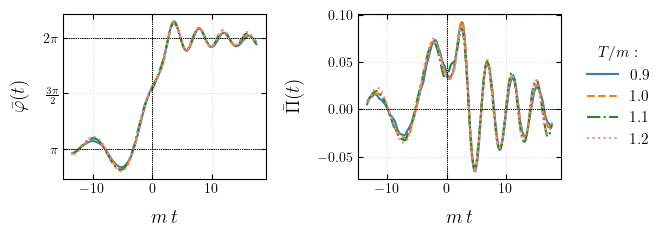

In [12]:
RcritList, critSlices = [], []
fig, ax = plt.subplots(1, 2, figsize = (7, 2.5))

indList = []
for ii, average_bubble in enumerate(reversed(bubbleList)):
    tmp  = tmpList[ii]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    labs = r'${}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)
    lsl = ('-' if tmp==0 else '--' if tmp==1 else '-.' if tmp==2 else ':')

    bubble2plot = average_bubble[0,:,:,70:-70]
    kinetic, engrad, potential = 0.5*bubble2plot[1]**2., 0.5*bubble2plot[2]**2., V(bubble2plot[0], lamb)

    totEbubble = kinetic + engrad + potential - V(phieq, lamb)

    # critical time is the slice where momentum is minimum
    off    = 100
    totkinprof = np.sum(kinetic, axis=1)
    indmin = np.argmin(totkinprof[off:]) + off
    if tmp==0:
        indmin += 1
        #indmin -= 5
        #indmin -= 20
    elif tmp==1:
        indmin += 1
    elif tmp==2:
        indmin += 2
    elif tmp==3:
        indmin += 1

    fldslice, momslice = bubble2plot[0,indmin], bubble2plot[1,indmin]
    gradslice, enslice = bubble2plot[2,indmin], totEbubble[indmin]

    critSlices.append(np.asarray([fldslice, momslice, enslice]))

    phimidprof = bubble2plot[0,:,np.argmax(fldslice)]
    mommidprof = bubble2plot[1,:,np.argmax(fldslice)]

    np.save(critfield_file(*exp_params), [fldslice, momslice, bubble2plot[2][indmin]])
    np.save(crittimes_file(*exp_params), indmin)
    np.save(critenerg_file(*exp_params), np.sum(enslice))

    peaks, _ = find_peaks(fldslice, height=np.pi/2.)
    ind      = np.argmax(fldslice[peaks[:]])
    fwhm     = peak_widths(fldslice, peaks[[ind]], rel_height=0.5)
    RcritList.append(fwhm[0][0]/2.)

    tlist = (np.arange(len(phimidprof)) - indmin) * dx * np.sqrt(m2(lamb))
    ax[0].plot(tlist, phimidprof, ls=lsl, label=labs)
    ax[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax[0].axhline(phieq, ls=':', color='k', linewidth=0.5)
    ax[0].axhline(2.*phieq, ls=':', color='k', linewidth=0.5)
    ax[0].axvline(0, ls=':', color='k', linewidth=0.5)

    ax[1].plot(tlist, mommidprof, ls=lsl, label=labs)
    ax[1].axvline(0., ls=':', color='k', linewidth=0.5)
    ax[1].axhline(0., ls=':', color='k', linewidth=0.5)

    for aa, axx in enumerate(ax.flatten()):
        axx.set_ylabel([r'$\bar{\varphi}(t)$', r'$\bar{\Pi}(t)$'][aa])
        axx.set_xlabel([r'$m\,t$',r'$m\,t$'][aa])

    leg = ax[1].legend(title=r'$T/m:$', ncol=1, frameon=False,loc='center right', bbox_to_anchor=(1.5, 0.5))

ax[1].grid(which='both', color='darkgray', ls=':', alpha=0.4)
ax[1].tick_params(direction='in', which='both', top=True, right=True)
ax[0].grid(which='both', color='darkgray', ls=':', alpha=0.4)
ax[0].tick_params(direction='in', which='both', top=True, right=True)

fig.tight_layout()
plt.savefig('./plots/critical_tevol.pdf', dpi=500)
plt.show()

In [13]:
np.save('./data/list_of_crit_indices.npy', indList)

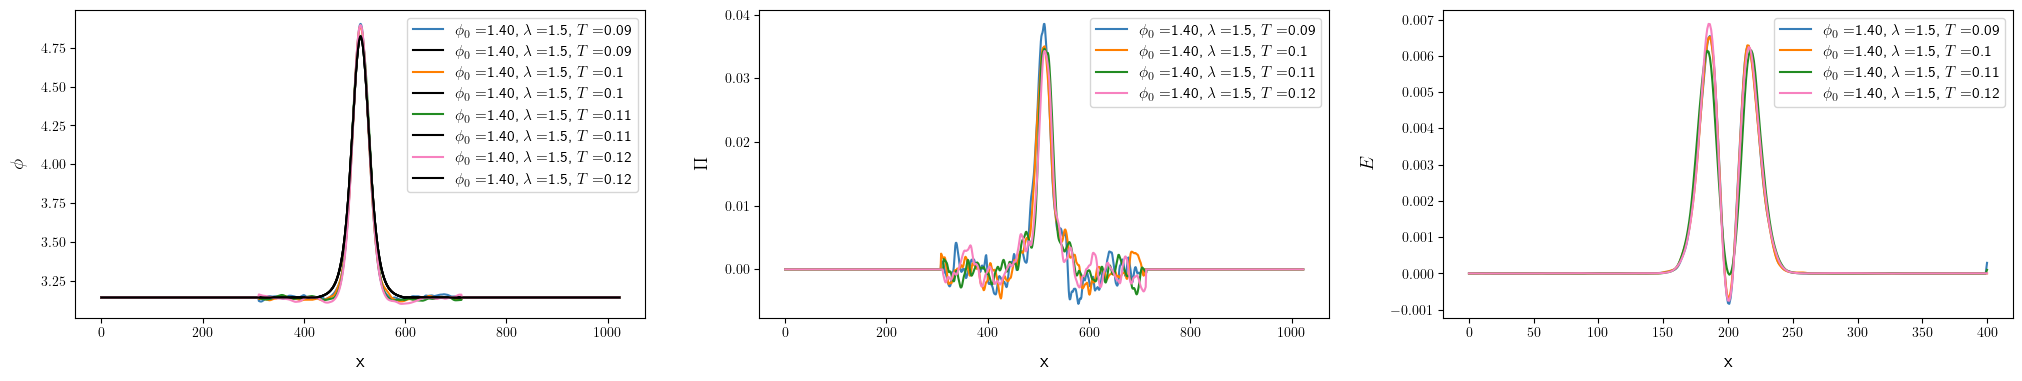

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (25, 4))
for ii, average_bubble in enumerate(bubbleList):
    tmp = tmpList[ii]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])
    labs = labl(lamb, phi0, temp)

    fldslice, momslice, enslice = critSlices[ii]
    thslice = instantonList[ii]

    fldslice = np.concatenate((fldslice, phieq*np.ones(nLat-len(fldslice))), axis=0)
    fldslice = np.roll(fldslice, nLat-int(-np.abs(nLat/2. - np.argmax(fldslice))))

    momslice = np.concatenate((momslice, np.zeros(nLat-len(momslice))), axis=0)
    momslice = np.roll(momslice, nLat-int(-np.abs(nLat/2. - np.argmax(momslice))))

    ax[0].plot(fldslice, label=labs)
    ax[0].plot(thslice, label=labs, color='k')
    ax[1].plot(momslice, label=labs)
    ax[2].plot(enslice, label=labs)

for aa, axx in enumerate(ax.flatten()):
    axx.set_xlabel('x')
    axx.set_ylabel([r'$\phi$', r'$\Pi$', r'$E$'][aa])
    axx.legend()
plt.show()

In [11]:
print(temp)
crit_soln_f90 = '(/'
for ind, iii in enumerate(fldslice-phieq):
    crit_soln_f90 = crit_soln_f90 + str(iii)
    if ind != len(fldslice)-1:
        crit_soln_f90 = crit_soln_f90 + ', '
crit_soln_f90 += '/)'
#print(crit_soln_f90)

0.12


In [11]:
crit_soln_f90 = '(/'
for ind, iii in enumerate(momslice):
    crit_soln_f90 = crit_soln_f90 + str(iii)
    if ind != len(momslice)-1:
        crit_soln_f90 = crit_soln_f90 + ', '
crit_soln_f90 += '/)'
#print(crit_soln_f90)

1024.0 1.5 1.3962634015954636 0.09
Decay time standard, radius: 512 75.5


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'


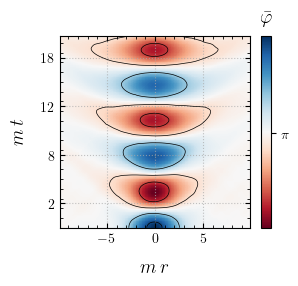

In [96]:
if True:
    for ii, average_bubble in enumerate(bubbleList):
        average_bubble = bubbleList[ii]
        tmp = tmpList[ii]
        if tmp!=0: break

        phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
        exp_params = np.asarray([nLat, lamb, phi0, temp])

        print(*exp_params)

        #name = '/gpfs/dpirvu/velocity_comparison/a_supercrit_instanton_x1024_phi01.3963_lambda1.5000_fields.dat'
        name = '/gpfs/dpirvu/velocity_comparison/b_supercrit_instanton_x1024_phi01.3963_lambda1.5000_fields.dat'
        critical_sim = extract_data(nLat, name)

        tdecay = max(0, np.shape(critical_sim)[1] - nLat//2)
        crit_thresh = right_Vmax.x + 5.*sigmafld

        print('Decay time standard, radius:', tdecay, crit_rad)
        critical_sim = critical_sim[0]
        truebubble = critical_sim[:nLat//4, 3*nLat//8 : 5*nLat//8]

        nN, nT      = np.shape(truebubble)
        tl,tr,xl,xr = 0, nT-1, -xcen, nN-1-xcen
        exts1       = np.array([xl, xr, tl, tr])*dx*np.sqrt(m2(lamb))
        tt1, xx1    = np.linspace(tl, tr, nT)*dx*np.sqrt(m2(lamb)), np.linspace(xl, xr, nN)*dx*np.sqrt(m2(lamb))
        ttt1, xxx1  = np.meshgrid(tt1, xx1)

        fig, ax = plt.subplots(1, 1, figsize = (3.2,3))
        ax.contour(xxx1, ttt1, truebubble.T, levels=3, aspect='auto', interpolation=None, extent=exts1, origin='lower', colors='k', linewidths=0.5)
        im0 = ax.imshow(truebubble, aspect='auto', interpolation='none', extent=exts1, origin='lower', cmap='RdBu')
        clb0 = plt.colorbar(im0, ax = ax, ticks = mticker.MultipleLocator(np.pi/2), format = mticker.FuncFormatter(multiple_formatter()))
        clb0.ax.set_title(r'$\bar{\varphi}$')

        for ai, aa in enumerate([ax]):
            aa.grid(ls=':', color='darkgray', alpha=0.7)
            aa.xaxis.set_minor_locator(MultipleLocator(1))
            aa.yaxis.set_minor_locator(MultipleLocator(1))
          #  aa.set_xlabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$')
          #  aa.set_ylabel(r'$\phi_0^{-1} \sqrt{V_0} \; t$')
            aa.set_xlabel(r'$m \, r$')
            aa.set_ylabel(r'$m \, t$')
            aa.yaxis.set_ticks_position('both')
            aa.xaxis.set_ticks_position('both')
            aa.tick_params(which='both', axis="y", direction="in")
            aa.tick_params(which='both', axis="x", direction="in")
           # a = aa.get_xticks().tolist()[1:-1:]
           # a = [round(al,2) for al in a]
           # aa.set_xticks(a)
           # aa.set_xticklabels(a)
            a = aa.get_yticks().tolist()[1:-1:2]
            a = [round(al,2) for al in a]
            aa.set_yticks(a)
            a = [r'${:.0f}$'.format(al) for al in a]
            aa.set_yticklabels(a)

        plt.tight_layout()
        #plt.savefig('./plots/a_critical_and_precursor'+str(temp)+'.pdf', bbox_inches='tight', dpi=500)
        plt.savefig('./plots/b_critical_and_precursor'+str(temp)+'.pdf', bbox_inches='tight', dpi=500)
        plt.show()


1024.0 1.5 1.3962634015954636 0.09
Decay time standard, radius: 143 75.5
(256, 256)


/var/folders/y9/3fb45z893_907tsjq09bjhbh0000gn/T/ipykernel_42072/641318941.py:46: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax[0].contour(xxx1, ttt1, truebubble.T, levels=3, aspect='auto', interpolation=None, extent=exts1, origin='lower', colors='k', linewidths=0.5)
/var/folders/y9/3fb45z893_907tsjq09bjhbh0000gn/T/ipykernel_42072/641318941.py:51: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax[1].contour(xxx2, ttt2, np.abs(np.pi-precursor.T), levels=3, aspect='auto', interpolation=None, extent=exts2, origin='lower', colors='k', linewidths=0.5)


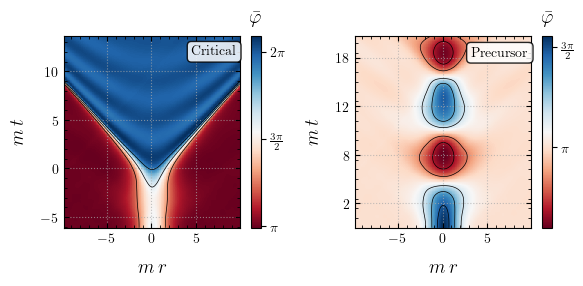

1024.0 1.5 1.3962634015954636 0.1
Decay time standard, radius: 152 74.5
(256, 256)


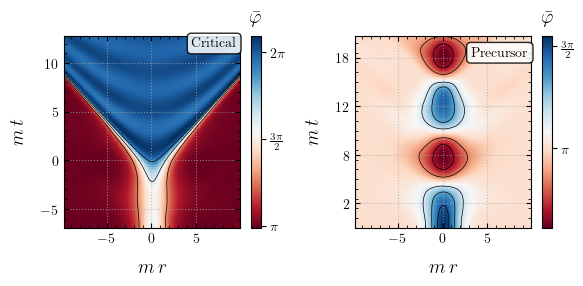

1024.0 1.5 1.3962634015954636 0.11
Decay time standard, radius: 133 74.0
(256, 256)


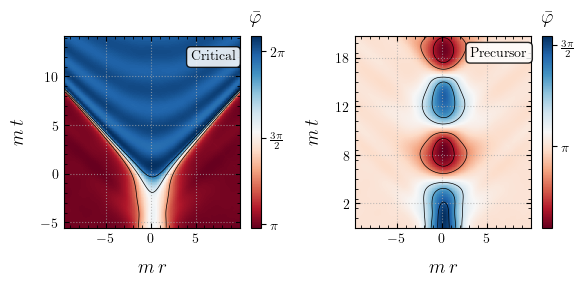

1024.0 1.5 1.3962634015954636 0.12
Decay time standard, radius: 136 74.5
(256, 256)


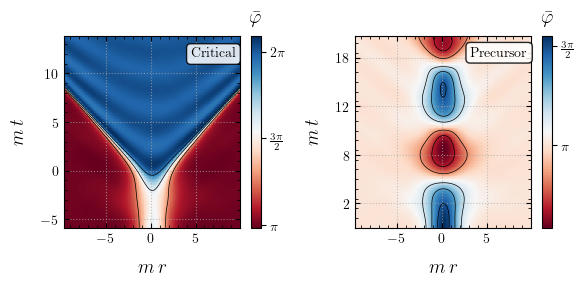

In [35]:
if True:
    for ii, average_bubble in enumerate(bubbleList):
        average_bubble = bubbleList[ii]
        tmp = tmpList[ii]
        phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
        exp_params = np.asarray([nLat, lamb, phi0, temp])

        print(*exp_params)

        critical_sim = extract_data(nLat, critical_sim_file(*exp_params))
        precursor_sim = extract_data(nLat, precursor_sim_file(*exp_params))

        titls = [r'$\rm Critical$', r'$\rm Precursor$']

        tdecay = max(0, np.shape(critical_sim)[1] - nLat//2)
        crit_thresh = right_Vmax.x + 5.*sigmafld
        critical_sim, crit_rad = centre_bubble(critical_sim, tdecay, phieq, crit_thresh)
        critical_sim = remove_collisions(critical_sim, phieq)

        print('Decay time standard, radius:', tdecay, crit_rad)
        critical_sim = critical_sim[0]
        precursor_sim = precursor_sim[0]

     #   critical_sim = gaussian_filter(critical_sim, sigma=5, mode='nearest')
     #   precursor_sim = gaussian_filter(precursor_sim, sigma=5, mode='nearest')

        truebubble = critical_sim[:nLat//4, 3*nLat//8 : 5*nLat//8]
        precursor  = precursor_sim[:nLat//4, 3*nLat//8 : 5*nLat//8]
        print(np.shape(precursor))


        nN, nT      = np.shape(truebubble)
        tcen, xcen  = find_nucleation_center(truebubble, phieq, crit_thresh, crit_rad//3)
        xcen += 1
        tl,tr,xl,xr = -tcen, nT-1-tcen, -xcen, nN-1-xcen
        exts1       = np.array([xl, xr, tl, tr])*dx*np.sqrt(m2(lamb))
        tt1, xx1    = np.linspace(tl, tr, nT)*dx*np.sqrt(m2(lamb)), np.linspace(xl, xr, nN)*dx*np.sqrt(m2(lamb))
        ttt1, xxx1  = np.meshgrid(tt1, xx1)

        tl,tr,xl,xr = 0, nT-1, -xcen, nN-1-xcen
        exts2       = np.array([xl, xr, tl, tr])*dx*np.sqrt(m2(lamb))
        tt2, xx2    = np.linspace(tl, tr, nT)*dx*np.sqrt(m2(lamb)), np.linspace(xl, xr, nN)*dx*np.sqrt(m2(lamb))
        ttt2, xxx2  = np.meshgrid(tt2, xx2)

        fig, ax = plt.subplots(1, 2, figsize = (6,3))
        ax[0].contour(xxx1, ttt1, truebubble.T, levels=3, aspect='auto', interpolation=None, extent=exts1, origin='lower', colors='k', linewidths=0.5)
        im0 = ax[0].imshow(truebubble, aspect='auto', interpolation='none', extent=exts1, origin='lower', cmap='RdBu')
        clb0 = plt.colorbar(im0, ax = ax[0], ticks = mticker.MultipleLocator(np.pi/2), format = mticker.FuncFormatter(multiple_formatter()))
        clb0.ax.set_title(r'$\bar{\varphi}$')

        ax[1].contour(xxx2, ttt2, np.abs(np.pi-precursor.T), levels=3, aspect='auto', interpolation=None, extent=exts2, origin='lower', colors='k', linewidths=0.5)
        im1 = ax[1].imshow(precursor, aspect='auto', interpolation='none', extent=exts2, origin='lower', cmap='RdBu')
        clb1 = plt.colorbar(im1, ax = ax[1], ticks = mticker.MultipleLocator(np.pi/2), format = mticker.FuncFormatter(multiple_formatter()))
        clb1.ax.set_title(r'$\bar{\varphi}$')

        for ai, aa in enumerate(ax):
          #  aa.text(5.5,.5,'TEST TEST TEST TEST',
          #            bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          #            ha='center', va='center') 
            aa.text([7.,6.4][ai], [12.,18.][ai], titls[ai], ha='center', va='center', \
                    bbox={'boxstyle':'round','facecolor':'white','alpha':0.85,'edgecolor':'k','pad':0.3}, fontsize=10)

            aa.grid(ls=':', color='darkgray', alpha=0.7)
            aa.xaxis.set_minor_locator(MultipleLocator(1))
            aa.yaxis.set_minor_locator(MultipleLocator(1))
          #  aa.set_xlabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$')
          #  aa.set_ylabel(r'$\phi_0^{-1} \sqrt{V_0} \; t$')
            aa.set_xlabel(r'$m \, r$')
            aa.set_ylabel(r'$m \, t$')
            aa.yaxis.set_ticks_position('both')
            aa.xaxis.set_ticks_position('both')
            aa.tick_params(which='both', axis="y", direction="in")
            aa.tick_params(which='both', axis="x", direction="in")
           # a = aa.get_xticks().tolist()[1:-1:]
           # a = [round(al,2) for al in a]
           # aa.set_xticks(a)
           # aa.set_xticklabels(a)
            a = aa.get_yticks().tolist()[1:-1:2]
            a = [round(al,2) for al in a]
            aa.set_yticks(a)
            a = [r'${:.0f}$'.format(al) for al in a]
            aa.set_yticklabels(a)

        plt.tight_layout()
        plt.savefig('./plots/critical_and_precursor'+str(temp)+'.pdf', bbox_inches='tight', dpi=500)
        plt.show()


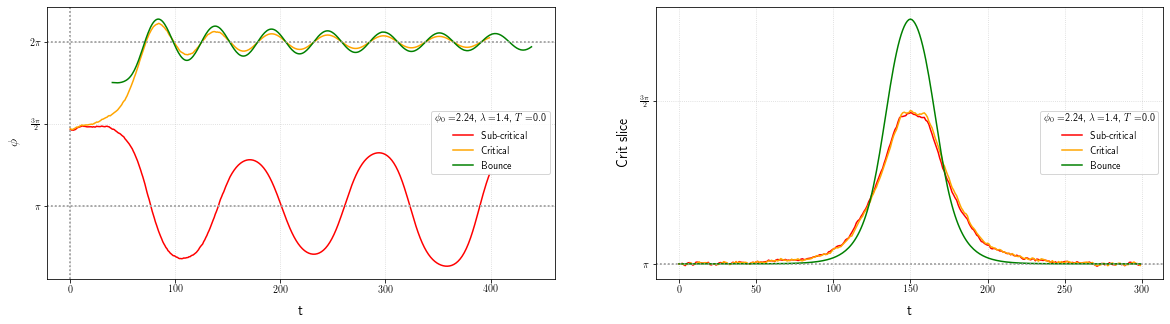

In [30]:
ii = 1
average_bubble = bubbleList[ii]
tmp  = tmpLoaded[ii]
temp = tempList[tmp]
lamb = lambList[tmp]
win  = 500

critSize = 30
colors = cycle(['r', 'orange', 'green', 'blue'])
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
for ii, average_bubble in enumerate(mainList):#, bubbleList[1][0,0]]):
    indmin = 0
    col = next(colors)

    bubble2plot = average_bubble[:400]
    nT, nN = np.shape(bubble2plot)

    slice = bubble2plot[indmin]
    xpeak = np.argmax(slice)
    phiprof = bubble2plot[:,xpeak]
    tind = np.argmax(phiprof)
    if ii==1:
        tindspecial = np.argmax(phiprof)
    
    if ii!=2:
        ax[0].plot(np.arange(len(phiprof)), phiprof, color=col, ls='-', label=titls[ii])
    else:
        t0,x0 = find_nucleation_center(bubble2plot, phieq, threshSize, critSize)
        ax[0].plot(np.arange(len(phiprof))-(tind-tindspecial), phiprof, color=col, ls='-', label=titls[ii])
    ax[0].axvline(indmin, ls=':', color='darkgray')
    ax[1].plot(slice[350:-350], color=col, ls='-', label=titls[ii])

    labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
    for aa, axx in enumerate(ax):
        axx.axhline(phieq, ls=':', color='darkgray')
        if aa==0:
            axx.axhline(2.*np.pi, ls=':', color='darkgray')
        axx.set_xlabel('t')
        axx.set_ylabel([r'$\phi$', 'Crit slice'][aa])
        axx.legend(loc='center right', title=labs)
        axx.grid(ls=':', color='darkgray', alpha=0.5)
        axx.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        axx.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

plt.savefig('./data/comparisons_crit_slices.pdf',bbox_inches='tight')
plt.show()